Kristen Swerzenski

DSC 630 Predictive Analytics

10 August 2024

## Predictive Analytics for Flight Delays: Enhancing Airline Efficiency and Passenger Experience

In [1]:
# Importing necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Reading in the data frame
df = pd.read_csv('2018.csv')
df.head()

,FL_DATE,OP_CARRIER,OP_CARRIER_FL_NUM,ORIGIN,DEST,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,TAXI_OUT,WHEELS_OFF,...,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,DISTANCE,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,Unnamed: 27
0,2018-01-01,UA,2429,EWR,DEN,1517,1512.0,-5.0,15.0,1527.0,...,268.0,250.0,225.0,1605.0,NaN,NaN,NaN,NaN,NaN,NaN
1,2018-01-01,UA,2427,LAS,SFO,1115,1107.0,-8.0,11.0,1118.0,...,99.0,83.0,65.0,414.0,NaN,NaN,NaN,NaN,NaN,NaN
2,2018-01-01,UA,2426,SNA,DEN,1335,1330.0,-5.0,15.0,1345.0,...,134.0,126.0,106.0,846.0,NaN,NaN,NaN,NaN,NaN,NaN
3,2018-01-01,UA,2425,RSW,ORD,1546,1552.0,6.0,19.0,1611.0,...,190.0,182.0,157.0,1120.0,NaN,NaN,NaN,NaN,NaN,NaN
4,2018-01-01,UA,2424,ORD,ALB,630,650.0,20.0,13.0,703.0,...,112.0,106.0,83.0,723.0,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
list(df.columns)

['FL_DATE',
 'OP_CARRIER',
 'OP_CARRIER_FL_NUM',
 'ORIGIN',
 'DEST',
 'CRS_DEP_TIME',
 'DEP_TIME',
 'DEP_DELAY',
 'TAXI_OUT',
 'WHEELS_OFF',
 'WHEELS_ON',
 'TAXI_IN',
 'CRS_ARR_TIME',
 'ARR_TIME',
 'ARR_DELAY',
 'CANCELLED',
 'CANCELLATION_CODE',
 'DIVERTED',
 'CRS_ELAPSED_TIME',
 'ACTUAL_ELAPSED_TIME',
 'AIR_TIME',
 'DISTANCE',
 'CARRIER_DELAY',
 'WEATHER_DELAY',
 'NAS_DELAY',
 'SECURITY_DELAY',
 'LATE_AIRCRAFT_DELAY',
 'Unnamed: 27']

### Data Preparation

Dropping unnecessary "Unnamed 27" column:

In [4]:
# Dropping an unnecessary column
df = df.drop('Unnamed: 27', axis=1)

Changing the airline carrier codes to actual airline names for easier interpretability during analysis:

In [5]:
# Mapping airline carrier codes to airline names for easier interpretability
carrier_map = {
    'WN': 'Southwest Airlines',
    'AA': 'American Airlines',
    'DL': 'Delta Airlines',
    'OO': 'Skywest Airlines',
    'UA': 'United Airlines',
    'B6': 'Jetblue Airways',
    'OH': 'PSA Airlines',
    'MQ': 'Envoy Air',
    'YX': 'Republic Airline',
    'AS': 'Alaska Airlines',
    'YV': 'Mesa Airlines',
    '9E': 'Endeavor Air',
    'EV': 'ExpressJet Airlines',
    'NK': 'Spirit Airlines',
    'F9': 'Frontier Airlines',
    'G4': 'Allegiant Air',
    'HA': 'Hawaiian Airlines',
    'VX': 'Virgin America'
}

# Replacing airline carrier code with the airline names
df['OP_CARRIER'] = df['OP_CARRIER'].replace(carrier_map)

Changing columns to lowercase for easier manipulation:

In [6]:
# Reformatting column names to all lowercase
df.columns = df.columns.str.lower()

In [7]:
# Checking data frame
df.head()

,fl_date,op_carrier,op_carrier_fl_num,origin,dest,crs_dep_time,dep_time,dep_delay,taxi_out,wheels_off,...,diverted,crs_elapsed_time,actual_elapsed_time,air_time,distance,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay
0,2018-01-01,United Airlines,2429,EWR,DEN,1517,1512.0,-5.0,15.0,1527.0,...,0.0,268.0,250.0,225.0,1605.0,NaN,NaN,NaN,NaN,NaN
1,2018-01-01,United Airlines,2427,LAS,SFO,1115,1107.0,-8.0,11.0,1118.0,...,0.0,99.0,83.0,65.0,414.0,NaN,NaN,NaN,NaN,NaN
2,2018-01-01,United Airlines,2426,SNA,DEN,1335,1330.0,-5.0,15.0,1345.0,...,0.0,134.0,126.0,106.0,846.0,NaN,NaN,NaN,NaN,NaN
3,2018-01-01,United Airlines,2425,RSW,ORD,1546,1552.0,6.0,19.0,1611.0,...,0.0,190.0,182.0,157.0,1120.0,NaN,NaN,NaN,NaN,NaN
4,2018-01-01,United Airlines,2424,ORD,ALB,630,650.0,20.0,13.0,703.0,...,0.0,112.0,106.0,83.0,723.0,NaN,NaN,NaN,NaN,NaN


Dropping rows missing values in more than 9 columns:

In [8]:
# Checking shape of data frame
df.shape

(7213446, 27)

In [9]:
# Dropping all rows with more than 9 missing values and rechecking shape
df = df.dropna(thresh=len(df.columns) - 9)
df.shape

(7094181, 27)

Reformatting flight departure and arrivla times into datetimes:

In [10]:
# Defining a function to convert float to datetime
def float_to_time(time_float):
    # Converting float to integer
    time_int = int(time_float)
    
    # Extracting hours and minutes
    hours = time_int // 100
    minutes = time_int % 100
    
    # Formatting as HH:MM
    return f'{hours:02d}:{minutes:02d}'

In [11]:
# Converting departure times to datetime using function
df['crs_dep_time'] = df['crs_dep_time'].apply(float_to_time)
df['dep_time'] = df['dep_time'].apply(float_to_time)
df.head()

,fl_date,op_carrier,op_carrier_fl_num,origin,dest,crs_dep_time,dep_time,dep_delay,taxi_out,wheels_off,...,diverted,crs_elapsed_time,actual_elapsed_time,air_time,distance,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay
0,2018-01-01,United Airlines,2429,EWR,DEN,15:17,15:12,-5.0,15.0,1527.0,...,0.0,268.0,250.0,225.0,1605.0,NaN,NaN,NaN,NaN,NaN
1,2018-01-01,United Airlines,2427,LAS,SFO,11:15,11:07,-8.0,11.0,1118.0,...,0.0,99.0,83.0,65.0,414.0,NaN,NaN,NaN,NaN,NaN
2,2018-01-01,United Airlines,2426,SNA,DEN,13:35,13:30,-5.0,15.0,1345.0,...,0.0,134.0,126.0,106.0,846.0,NaN,NaN,NaN,NaN,NaN
3,2018-01-01,United Airlines,2425,RSW,ORD,15:46,15:52,6.0,19.0,1611.0,...,0.0,190.0,182.0,157.0,1120.0,NaN,NaN,NaN,NaN,NaN
4,2018-01-01,United Airlines,2424,ORD,ALB,06:30,06:50,20.0,13.0,703.0,...,0.0,112.0,106.0,83.0,723.0,NaN,NaN,NaN,NaN,NaN


In [12]:
# Converting arrival times to datetime using function
df['crs_arr_time'] = df['crs_arr_time'].apply(float_to_time)
df['arr_time'] = df['arr_time'].apply(float_to_time)
df.head()

,fl_date,op_carrier,op_carrier_fl_num,origin,dest,crs_dep_time,dep_time,dep_delay,taxi_out,wheels_off,...,diverted,crs_elapsed_time,actual_elapsed_time,air_time,distance,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay
0,2018-01-01,United Airlines,2429,EWR,DEN,15:17,15:12,-5.0,15.0,1527.0,...,0.0,268.0,250.0,225.0,1605.0,NaN,NaN,NaN,NaN,NaN
1,2018-01-01,United Airlines,2427,LAS,SFO,11:15,11:07,-8.0,11.0,1118.0,...,0.0,99.0,83.0,65.0,414.0,NaN,NaN,NaN,NaN,NaN
2,2018-01-01,United Airlines,2426,SNA,DEN,13:35,13:30,-5.0,15.0,1345.0,...,0.0,134.0,126.0,106.0,846.0,NaN,NaN,NaN,NaN,NaN
3,2018-01-01,United Airlines,2425,RSW,ORD,15:46,15:52,6.0,19.0,1611.0,...,0.0,190.0,182.0,157.0,1120.0,NaN,NaN,NaN,NaN,NaN
4,2018-01-01,United Airlines,2424,ORD,ALB,06:30,06:50,20.0,13.0,703.0,...,0.0,112.0,106.0,83.0,723.0,NaN,NaN,NaN,NaN,NaN


Binning arrival and departure times into hours:

In [13]:
# Defining a function to extract hour
def get_hour(time_str):
    hour = time_str.split(':')[0]
    return f'{hour}:00'

# Applying the function to get hour of the flights
df['crs_dep_hour'] = df['crs_dep_time'].apply(get_hour)
df['dep_hour'] = df['dep_time'].apply(get_hour)
df['crs_arr_hour'] = df['crs_arr_time'].apply(get_hour)
df['arr_hour'] = df['arr_time'].apply(get_hour)

df.head()

,fl_date,op_carrier,op_carrier_fl_num,origin,dest,crs_dep_time,dep_time,dep_delay,taxi_out,wheels_off,...,distance,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay,crs_dep_hour,dep_hour,crs_arr_hour,arr_hour
0,2018-01-01,United Airlines,2429,EWR,DEN,15:17,15:12,-5.0,15.0,1527.0,...,1605.0,NaN,NaN,NaN,NaN,NaN,15:00,15:00,17:00,17:00
1,2018-01-01,United Airlines,2427,LAS,SFO,11:15,11:07,-8.0,11.0,1118.0,...,414.0,NaN,NaN,NaN,NaN,NaN,11:00,11:00,12:00,12:00
2,2018-01-01,United Airlines,2426,SNA,DEN,13:35,13:30,-5.0,15.0,1345.0,...,846.0,NaN,NaN,NaN,NaN,NaN,13:00,13:00,16:00,16:00
3,2018-01-01,United Airlines,2425,RSW,ORD,15:46,15:52,6.0,19.0,1611.0,...,1120.0,NaN,NaN,NaN,NaN,NaN,15:00,15:00,17:00,17:00
4,2018-01-01,United Airlines,2424,ORD,ALB,06:30,06:50,20.0,13.0,703.0,...,723.0,NaN,NaN,NaN,NaN,NaN,06:00,06:00,09:00,09:00


Binning flights by season:

In [14]:
# Ensuring fl_date is datetime
df['fl_date'] = pd.to_datetime(df['fl_date'])

# Defining a function to get season based on month
def get_season(month):
    if month in [12, 1, 2]:
        return 'winter'
    elif month in [3, 4, 5]:
        return 'spring'
    elif month in [6, 7, 8]:
        return 'summer'
    else:
        return 'fall'

# Applying the function to create season variable
df['season'] = df['fl_date'].dt.month.apply(get_season)

Replacing NaN values in delay columns for non-delayed flights with 0s:

In [15]:
# Defining columns to replace missing values
columns_to_replace = ['carrier_delay', 'weather_delay', 'nas_delay', 
                      'security_delay', 'late_aircraft_delay']
# Filling all missing values with 0s
df[columns_to_replace] = df[columns_to_replace].fillna(0)

In [16]:
# Checking missing value counts
nan_counts = df.isna().sum()
print(nan_counts)

fl_date                      0
op_carrier                   0
op_carrier_fl_num            0
origin                       0
dest                         0
crs_dep_time                 0
dep_time                     0
dep_delay                 4725
taxi_out                     0
wheels_off                   0
wheels_on                    0
taxi_in                      0
crs_arr_time                 0
arr_time                     0
arr_delay                17775
cancelled                    0
cancellation_code      7094181
diverted                     0
crs_elapsed_time             0
actual_elapsed_time      15177
air_time                 15177
distance                     0
carrier_delay                0
weather_delay                0
nas_delay                    0
security_delay               0
late_aircraft_delay          0
crs_dep_hour                 0
dep_hour                     0
crs_arr_hour                 0
arr_hour                     0
season                       0
dtype: i

Adding day of week feature:

In [17]:
# Extracting day of week from date 
df['day_of_week'] = df['fl_date'].dt.dayofweek
df.head()

,fl_date,op_carrier,op_carrier_fl_num,origin,dest,crs_dep_time,dep_time,dep_delay,taxi_out,wheels_off,...,weather_delay,nas_delay,security_delay,late_aircraft_delay,crs_dep_hour,dep_hour,crs_arr_hour,arr_hour,season,day_of_week
0,2018-01-01,United Airlines,2429,EWR,DEN,15:17,15:12,-5.0,15.0,1527.0,...,0.0,0.0,0.0,0.0,15:00,15:00,17:00,17:00,winter,0
1,2018-01-01,United Airlines,2427,LAS,SFO,11:15,11:07,-8.0,11.0,1118.0,...,0.0,0.0,0.0,0.0,11:00,11:00,12:00,12:00,winter,0
2,2018-01-01,United Airlines,2426,SNA,DEN,13:35,13:30,-5.0,15.0,1345.0,...,0.0,0.0,0.0,0.0,13:00,13:00,16:00,16:00,winter,0
3,2018-01-01,United Airlines,2425,RSW,ORD,15:46,15:52,6.0,19.0,1611.0,...,0.0,0.0,0.0,0.0,15:00,15:00,17:00,17:00,winter,0
4,2018-01-01,United Airlines,2424,ORD,ALB,06:30,06:50,20.0,13.0,703.0,...,0.0,0.0,0.0,0.0,06:00,06:00,09:00,09:00,winter,0


In [18]:
# Mapping day to day count 
day_mapping = {
    0: 'Monday',
    1: 'Tuesday',
    2: 'Wednesday',
    3: 'Thursday',
    4: 'Friday',
    5: 'Saturday',
    6: 'Sunday'
}

# Applying mapping
df['day_of_week'] = df['day_of_week'].map(day_mapping)

Adding month:

In [19]:
# Extracting month from date
df['month'] = df['fl_date'].dt.month

In [20]:
# Mapping month name to month number
month_mapping = {
    1: 'January',
    2: 'February',
    3: 'March',
    4: 'April',
    5: 'May',
    6: 'June',
    7: 'July',
    8: 'August',
    9: 'September',
    10: 'October',
    11: 'November',
    12: 'December'
}

# Applying month name mapping
df['month'] = df['month'].map(month_mapping)

# Checking dataframe
df.head()

,fl_date,op_carrier,op_carrier_fl_num,origin,dest,crs_dep_time,dep_time,dep_delay,taxi_out,wheels_off,...,nas_delay,security_delay,late_aircraft_delay,crs_dep_hour,dep_hour,crs_arr_hour,arr_hour,season,day_of_week,month
0,2018-01-01,United Airlines,2429,EWR,DEN,15:17,15:12,-5.0,15.0,1527.0,...,0.0,0.0,0.0,15:00,15:00,17:00,17:00,winter,Monday,January
1,2018-01-01,United Airlines,2427,LAS,SFO,11:15,11:07,-8.0,11.0,1118.0,...,0.0,0.0,0.0,11:00,11:00,12:00,12:00,winter,Monday,January
2,2018-01-01,United Airlines,2426,SNA,DEN,13:35,13:30,-5.0,15.0,1345.0,...,0.0,0.0,0.0,13:00,13:00,16:00,16:00,winter,Monday,January
3,2018-01-01,United Airlines,2425,RSW,ORD,15:46,15:52,6.0,19.0,1611.0,...,0.0,0.0,0.0,15:00,15:00,17:00,17:00,winter,Monday,January
4,2018-01-01,United Airlines,2424,ORD,ALB,06:30,06:50,20.0,13.0,703.0,...,0.0,0.0,0.0,06:00,06:00,09:00,09:00,winter,Monday,January


### Exploratory Analysis and Visualizations

In [21]:
# Getting basic descriptive statistics about data
df.describe()

,fl_date,op_carrier_fl_num,dep_delay,taxi_out,wheels_off,wheels_on,taxi_in,arr_delay,cancelled,diverted,crs_elapsed_time,actual_elapsed_time,air_time,distance,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay
count,7094181,7.094181e+06,7.089456e+06,7.094181e+06,7.094181e+06,7.094181e+06,7.094181e+06,7.076406e+06,7094181.0,7.094181e+06,7.094181e+06,7.079004e+06,7.079004e+06,7.094181e+06,7.094181e+06,7.094181e+06,7.094181e+06,7.094181e+06,7.094181e+06
mean,2018-07-03 16:55:47.567477504,2.598118e+03,9.923062e+00,1.740882e+01,1.357752e+03,1.462162e+03,7.601244e+00,5.048581e+00,0.0,2.139218e-03,1.413900e+02,1.364999e+02,1.115020e+02,8.026319e+02,3.709657e+00,6.933958e-01,3.029023e+00,1.783589e-02,4.889790e+00
min,2018-01-01 00:00:00,1.000000e+00,-1.220000e+02,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,-1.200000e+02,0.0,0.000000e+00,-9.900000e+01,1.400000e+01,7.000000e+00,3.100000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2018-04-06 00:00:00,1.021000e+03,-5.000000e+00,1.100000e+01,9.320000e+02,1.044000e+03,4.000000e+00,-1.400000e+01,0.0,0.000000e+00,8.800000e+01,8.300000e+01,6.000000e+01,3.630000e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2018-07-05 00:00:00,2.122000e+03,-2.000000e+00,1.500000e+01,1.340000e+03,1.502000e+03,6.000000e+00,-6.000000e+00,0.0,0.000000e+00,1.220000e+02,1.180000e+02,9.200000e+01,6.340000e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,2018-10-01 00:00:00,4.062000e+03,7.000000e+00,2.000000e+01,1.759000e+03,1.911000e+03,9.000000e+00,8.000000e+00,0.0,0.000000e+00,1.710000e+02,1.670000e+02,1.410000e+02,1.035000e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,2018-12-31 00:00:00,7.909000e+03,2.710000e+03,1.960000e+02,2.400000e+03,2.400000e+03,2.590000e+02,2.692000e+03,0.0,1.000000e+00,7.040000e+02,7.570000e+02,6.960000e+02,4.983000e+03,2.109000e+03,2.692000e+03,1.848000e+03,9.870000e+02,2.454000e+03
std,NaN,1.858246e+03,4.468723e+01,9.917487e+00,5.059393e+02,5.334672e+02,6.064800e+00,4.692664e+01,0.0,4.620219e-02,7.350415e+01,7.313758e+01,7.111293e+01,5.994275e+02,2.683462e+01,1.317596e+01,1.687015e+01,1.386604e+00,2.396128e+01


In [22]:
# Reorganizing data frame into delayed and cancelled flights for easier visualization
delayed_flights = df[(df['dep_delay'] > 0) | (df['arr_delay'] > 0)]
cancelled_flights = df[df['cancelled'] == 1]
delayed_and_cancelled_flights = pd.concat([delayed_flights, cancelled_flights]).drop_duplicates()
delayed_and_cancelled_flights.reset_index(drop=True, inplace=True)
delayed_and_cancelled_flights.head()

,fl_date,op_carrier,op_carrier_fl_num,origin,dest,crs_dep_time,dep_time,dep_delay,taxi_out,wheels_off,...,nas_delay,security_delay,late_aircraft_delay,crs_dep_hour,dep_hour,crs_arr_hour,arr_hour,season,day_of_week,month
0,2018-01-01,United Airlines,2425,RSW,ORD,15:46,15:52,6.0,19.0,1611.0,...,0.0,0.0,0.0,15:00,15:00,17:00,17:00,winter,Monday,January
1,2018-01-01,United Airlines,2424,ORD,ALB,06:30,06:50,20.0,13.0,703.0,...,0.0,0.0,0.0,06:00,06:00,09:00,09:00,winter,Monday,January
2,2018-01-01,United Airlines,2422,ORD,OMA,22:41,22:44,3.0,15.0,2259.0,...,0.0,0.0,0.0,22:00,22:00,00:00,00:00,winter,Monday,January
3,2018-01-01,United Airlines,2419,SMF,EWR,22:24,22:37,13.0,10.0,2247.0,...,0.0,0.0,0.0,22:00,22:00,06:00,06:00,winter,Monday,January
4,2018-01-01,United Airlines,2416,ORD,CLE,20:59,23:00,121.0,24.0,2324.0,...,8.0,0.0,0.0,20:00,23:00,23:00,01:00,winter,Monday,January


In [23]:
delayed_and_cancelled_flights.shape

(3179821, 34)

Plotting the number of delayed flights by airline:

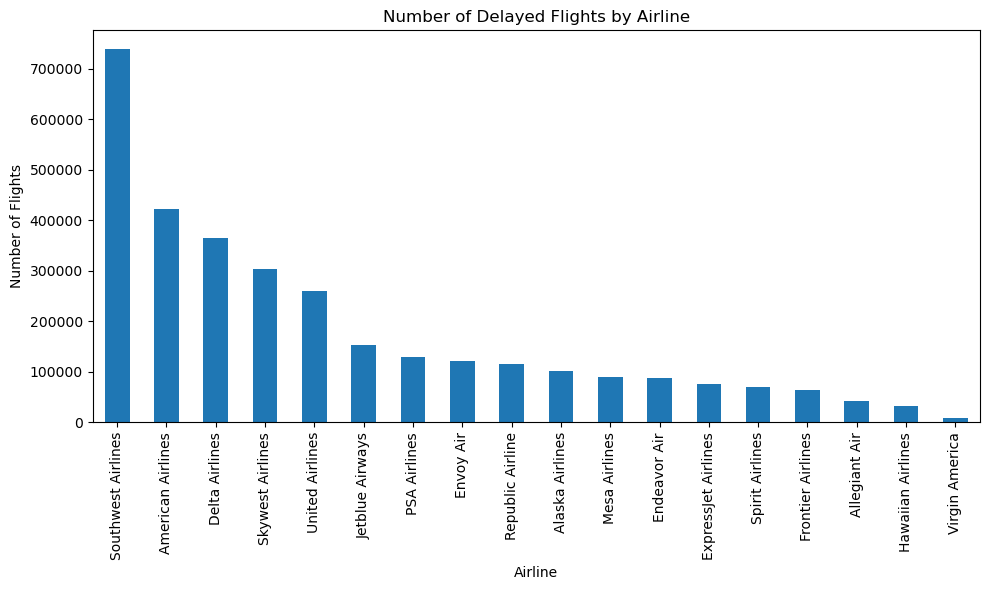

In [24]:
# Getting a count of the number of delayed flights by airline
airline_counts = delayed_flights['op_carrier'].value_counts()

# Plotting the counts
plt.figure(figsize=(10, 6))
airline_counts.plot(kind='bar')
plt.title('Number of Delayed Flights by Airline')
plt.xlabel('Airline')
plt.ylabel('Number of Flights')
plt.tight_layout()
plt.savefig("delays_by_airline.png")
plt.show()

Comparing total number of operated flights to total number of delayed flights:

In [25]:
# Getting total flight counts and delayed flight counts by each carrier
total_flight_counts = df['op_carrier'].value_counts()
delayed_flight_counts = delayed_flights['op_carrier'].value_counts()

# Combining counts into a data frame and checking the data frame
flight_counts = pd.DataFrame({
    'Total Flights': total_flight_counts,
    'Delayed Flights': delayed_flight_counts
}).fillna(0)

flight_counts

,Total Flights,Delayed Flights
op_carrier,,
Alaska Airlines,243356,102537
Allegiant Air,95412,42249
American Airlines,901642,422241
Delta Airlines,945646,365860
Endeavor Air,239477,87376
Envoy Air,285230,120946
ExpressJet Airlines,197162,76746
Frontier Airlines,117673,64094
Hawaiian Airlines,83454,31868


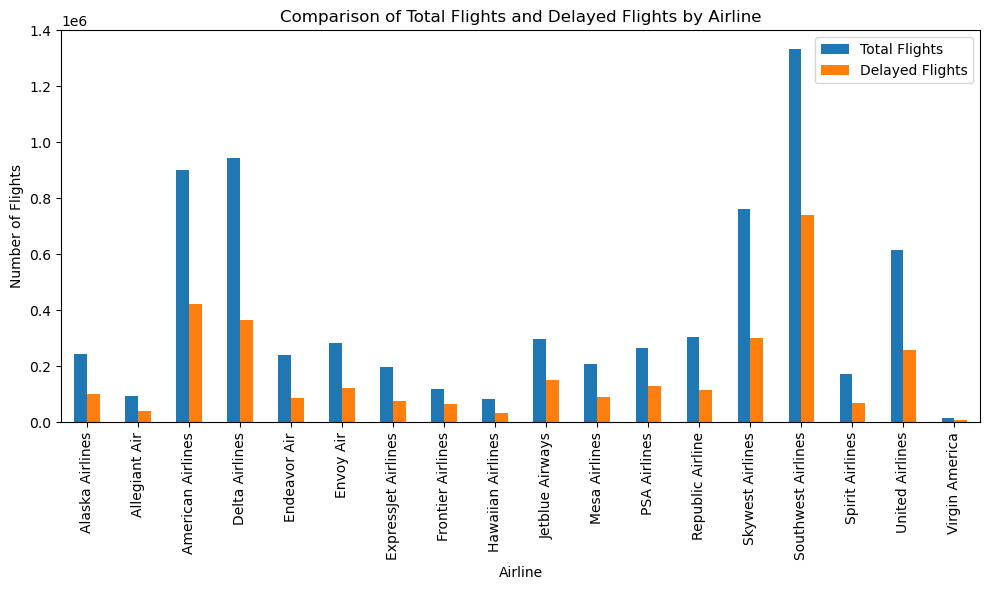

In [26]:
# Ploting the side by side bar chart
flight_counts.plot(kind='bar', figsize=(10, 6))
plt.title('Comparison of Total Flights and Delayed Flights by Airline')
plt.xlabel('Airline')
plt.ylabel('Number of Flights')
plt.tight_layout()
plt.savefig("flights_comparison_by_airline.png")
plt.show()

Plotting average departure time delay by airline:

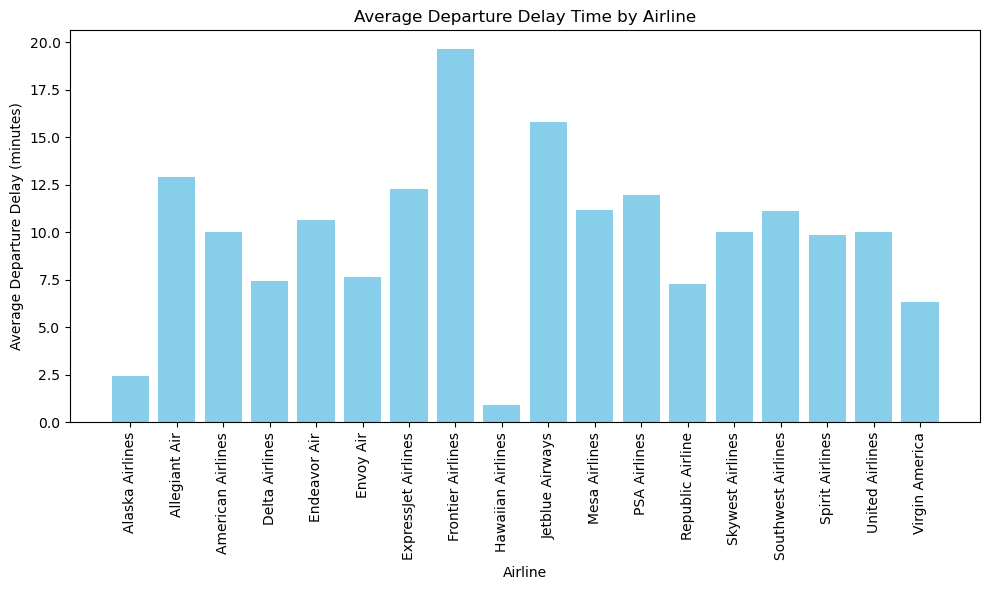

In [27]:
# Calculating average length of departure delay by airline
avg_delay_by_airline = df.groupby('op_carrier')['dep_delay'].mean().reset_index()

# Plotting the bar chart of average departure delay times
plt.figure(figsize=(10, 6))
plt.bar(avg_delay_by_airline['op_carrier'], avg_delay_by_airline['dep_delay'], color='skyblue')
plt.xlabel('Airline')
plt.ylabel('Average Departure Delay (minutes)')
plt.title('Average Departure Delay Time by Airline')
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig("delay_time_by_airlinet.png")
plt.show()

Plotting total flights over time with total delayed flights over time:

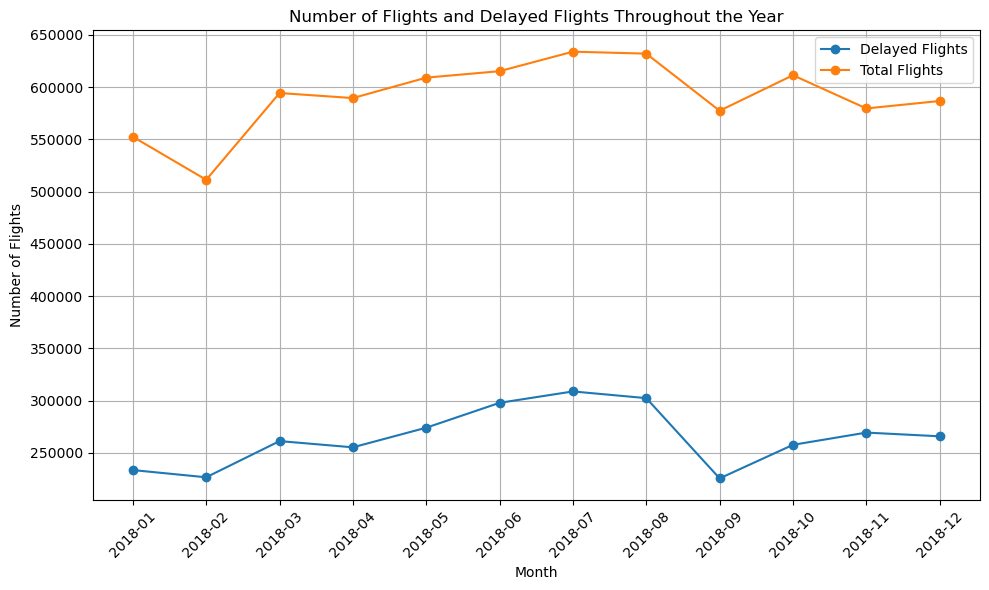

In [28]:
# Grouping by fl_date and count delays for delayed flights
daily_delay_counts = delayed_flights.groupby(delayed_flights['fl_date'].dt.to_period('M')).size()

# Grouping by fl_date and count total flights
total_flights_counts = df.groupby(df['fl_date'].dt.to_period('M')).size()

# Plotting the line chart
plt.figure(figsize=(10, 6))

# Plotting delayed flights
plt.plot(daily_delay_counts.index.astype(str), daily_delay_counts.values, marker='o', 
         linestyle='-', label='Delayed Flights')

# Plotting total flights
plt.plot(total_flights_counts.index.astype(str), total_flights_counts.values, marker='o', 
         linestyle='-', label='Total Flights')

plt.xlabel('Month')
plt.ylabel('Number of Flights')
plt.title('Number of Flights and Delayed Flights Throughout the Year')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("delayed_flights_over_time.png")
plt.show()

Plotting the average departure and arrival delay times at the 20 'busiest' airports (airports with the most departing flights):

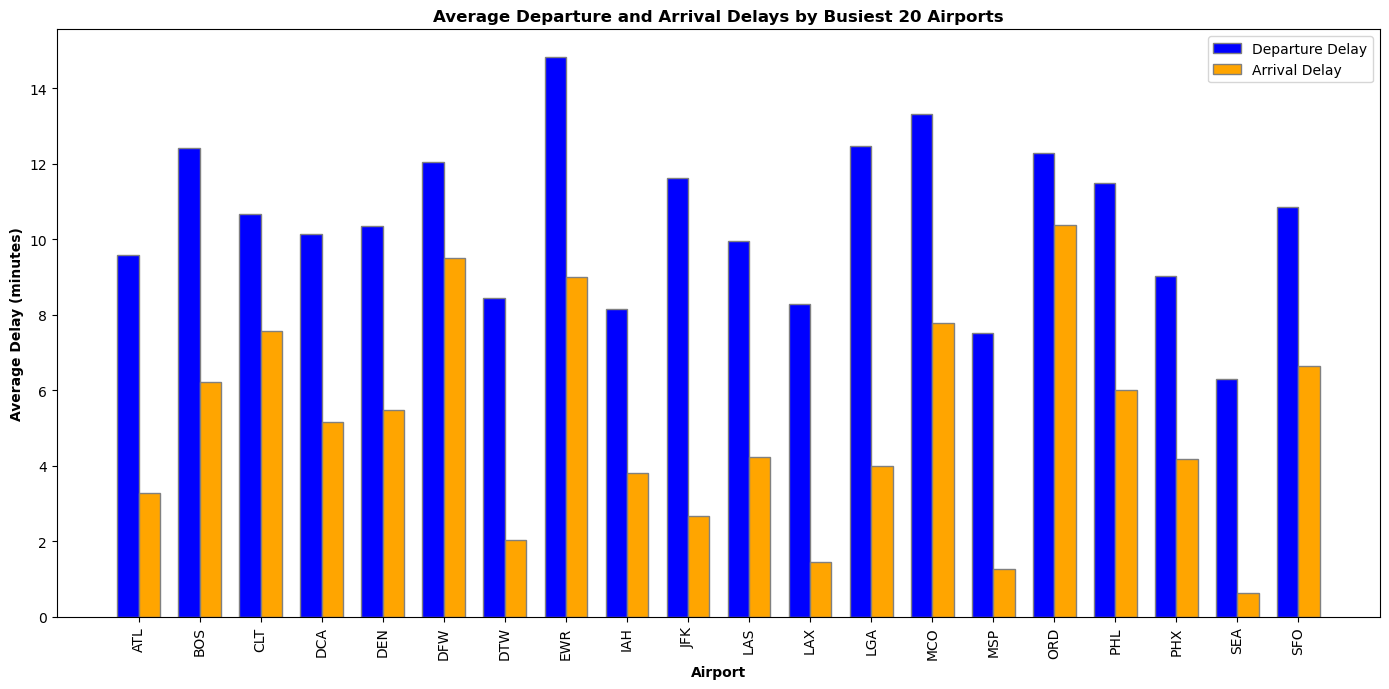

In [29]:
# Defining the number of top airports to display
top_n = 20

# Calculating the number of flights per airport
airport_flight_counts = df['origin'].value_counts().head(top_n)

# Filtering the data frame to include only the top N airports
top_airports_df = df[df['origin'].isin(airport_flight_counts.index)]

# Grouping by origin airport and calculating average delays
average_delays_by_airport = top_airports_df.groupby('origin').agg({
    'dep_delay': 'mean',
    'arr_delay': 'mean'
}).reset_index()

# Sorting by airport code for better visualization
average_delays_by_airport = average_delays_by_airport.sort_values('origin')

# Creating the plot
fig, ax = plt.subplots(figsize=(14, 7))

# Defining the bar width
bar_width = 0.35

# Setting the positions of the bars on the x-axis
r1 = np.arange(len(average_delays_by_airport))
r2 = [x + bar_width for x in r1]

# Creating the bars
ax.bar(r1, average_delays_by_airport['dep_delay'], color='blue', 
       width=bar_width, edgecolor='grey', label='Departure Delay')
ax.bar(r2, average_delays_by_airport['arr_delay'], color='orange', 
       width=bar_width, edgecolor='grey', label='Arrival Delay')

# Adding labels
ax.set_xlabel('Airport', fontweight='bold')
ax.set_ylabel('Average Delay (minutes)', fontweight='bold')
ax.set_title(f'Average Departure and Arrival Delays by Busiest {top_n} Airports', 
             fontweight='bold')
ax.set_xticks([r + bar_width / 2 for r in range(len(average_delays_by_airport))])
ax.set_xticklabels(average_delays_by_airport['origin'], rotation=90)
# Adding a legend and displaying the plot
ax.legend()
plt.tight_layout()
plt.savefig("dep_delay_by_airport.png")
plt.show()

### Additional Data Preparation for Modeling:

In [30]:
# Setting data frame viewing options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

Creating binary variable of whether or not flight was delayed:

In [31]:
# Creating binary variable for delay and checking data frame
df['delayed'] = df['dep_delay'].apply(lambda x: 1 if x > 0 else 0)
df.head()

,fl_date,op_carrier,op_carrier_fl_num,origin,dest,crs_dep_time,dep_time,dep_delay,taxi_out,wheels_off,wheels_on,taxi_in,crs_arr_time,arr_time,arr_delay,cancelled,cancellation_code,diverted,crs_elapsed_time,actual_elapsed_time,air_time,distance,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay,crs_dep_hour,dep_hour,crs_arr_hour,arr_hour,season,day_of_week,month,delayed
0,2018-01-01,United Airlines,2429,EWR,DEN,15:17,15:12,-5.0,15.0,1527.0,1712.0,10.0,17:45,17:22,-23.0,0.0,NaN,0.0,268.0,250.0,225.0,1605.0,0.0,0.0,0.0,0.0,0.0,15:00,15:00,17:00,17:00,winter,Monday,January,0
1,2018-01-01,United Airlines,2427,LAS,SFO,11:15,11:07,-8.0,11.0,1118.0,1223.0,7.0,12:54,12:30,-24.0,0.0,NaN,0.0,99.0,83.0,65.0,414.0,0.0,0.0,0.0,0.0,0.0,11:00,11:00,12:00,12:00,winter,Monday,January,0
2,2018-01-01,United Airlines,2426,SNA,DEN,13:35,13:30,-5.0,15.0,1345.0,1631.0,5.0,16:49,16:36,-13.0,0.0,NaN,0.0,134.0,126.0,106.0,846.0,0.0,0.0,0.0,0.0,0.0,13:00,13:00,16:00,16:00,winter,Monday,January,0
3,2018-01-01,United Airlines,2425,RSW,ORD,15:46,15:52,6.0,19.0,1611.0,1748.0,6.0,17:56,17:54,-2.0,0.0,NaN,0.0,190.0,182.0,157.0,1120.0,0.0,0.0,0.0,0.0,0.0,15:00,15:00,17:00,17:00,winter,Monday,January,1
4,2018-01-01,United Airlines,2424,ORD,ALB,06:30,06:50,20.0,13.0,703.0,926.0,10.0,09:22,09:36,14.0,0.0,NaN,0.0,112.0,106.0,83.0,723.0,0.0,0.0,0.0,0.0,0.0,06:00,06:00,09:00,09:00,winter,Monday,January,1


Dropping additional columns not needed for classification:

In [32]:
# Defining columns to drop
columns_to_drop_delay_cat = ['op_carrier_fl_num', 'crs_dep_time', 'dep_time', 'taxi_out', 'wheels_off', 'wheels_on', 
                                'taxi_in', 'crs_arr_time', 'arr_time', 'arr_delay', 'cancellation_code', 'diverted', 
                                'carrier_delay', 'crs_elapsed_time', 'actual_elapsed_time', 'air_time', 'distance',
                                'weather_delay', 'nas_delay', 'security_delay', 'actual_elapsed_time',
                                'late_aircraft_delay', 'dep_hour', 'arr_hour', 'fl_date', 'arr_delay', 'dep_delay']

In [33]:
# Dropping columns
cat_df = df.drop(columns_to_drop_delay_cat, axis=1)
cat_df.head()

,op_carrier,origin,dest,cancelled,crs_dep_hour,crs_arr_hour,season,day_of_week,month,delayed
0,United Airlines,EWR,DEN,0.0,15:00,17:00,winter,Monday,January,0
1,United Airlines,LAS,SFO,0.0,11:00,12:00,winter,Monday,January,0
2,United Airlines,SNA,DEN,0.0,13:00,16:00,winter,Monday,January,0
3,United Airlines,RSW,ORD,0.0,15:00,17:00,winter,Monday,January,1
4,United Airlines,ORD,ALB,0.0,06:00,09:00,winter,Monday,January,1


Dropping flights that were cancelled:

In [34]:
# Filtering out flights that were cancelled
cat_df = cat_df[cat_df['cancelled'] == 0]

In [35]:
# Dropping cancelled column
cat_df = cat_df.drop('cancelled', axis=1)
cat_df.head()

,op_carrier,origin,dest,crs_dep_hour,crs_arr_hour,season,day_of_week,month,delayed
0,United Airlines,EWR,DEN,15:00,17:00,winter,Monday,January,0
1,United Airlines,LAS,SFO,11:00,12:00,winter,Monday,January,0
2,United Airlines,SNA,DEN,13:00,16:00,winter,Monday,January,0
3,United Airlines,RSW,ORD,15:00,17:00,winter,Monday,January,1
4,United Airlines,ORD,ALB,06:00,09:00,winter,Monday,January,1


One-hot encoding all categorical variables for modeling:

In [36]:
# One-hot enciding all variables
cat_df = pd.get_dummies(cat_df, drop_first=True)
cat_df.head()

,delayed,op_carrier_Allegiant Air,op_carrier_American Airlines,op_carrier_Delta Airlines,op_carrier_Endeavor Air,op_carrier_Envoy Air,op_carrier_ExpressJet Airlines,op_carrier_Frontier Airlines,op_carrier_Hawaiian Airlines,op_carrier_Jetblue Airways,op_carrier_Mesa Airlines,op_carrier_PSA Airlines,op_carrier_Republic Airline,op_carrier_Skywest Airlines,op_carrier_Southwest Airlines,op_carrier_Spirit Airlines,op_carrier_United Airlines,op_carrier_Virgin America,origin_ABI,origin_ABQ,origin_ABR,origin_ABY,origin_ACK,origin_ACT,origin_ACV,origin_ACY,origin_ADK,origin_ADQ,origin_AEX,origin_AGS,origin_AKN,origin_ALB,origin_ALO,origin_AMA,origin_ANC,origin_APN,origin_ART,origin_ASE,origin_ATL,origin_ATW,origin_AUS,origin_AVL,origin_AVP,origin_AZA,origin_AZO,origin_BDL,origin_BET,origin_BFF,origin_BFL,origin_BGM,origin_BGR,origin_BHM,origin_BIL,origin_BIS,origin_BJI,origin_BKG,origin_BLI,origin_BLV,origin_BMI,origin_BNA,origin_BOI,origin_BOS,origin_BPT,origin_BQK,origin_BQN,origin_BRD,origin_BRO,origin_BRW,origin_BTM,origin_BTR,origin_BTV,origin_BUF,origin_BUR,origin_BWI,origin_BZN,origin_CAE,origin_CAK,origin_CDC,origin_CDV,origin_CGI,origin_CHA,origin_CHO,origin_CHS,origin_CID,origin_CIU,origin_CKB,origin_CLE,origin_CLL,origin_CLT,origin_CMH,origin_CMI,origin_CMX,origin_CNY,origin_COD,origin_COS,origin_COU,origin_CPR,origin_CRP,origin_CRW,origin_CSG,origin_CVG,origin_CWA,origin_CYS,origin_DAB,origin_DAL,origin_DAY,origin_DBQ,origin_DCA,origin_DEN,origin_DFW,origin_DHN,origin_DLG,origin_DLH,origin_DRO,origin_DRT,origin_DSM,origin_DTW,origin_DVL,origin_EAR,origin_EAU,origin_ECP,origin_EGE,origin_EKO,origin_ELM,origin_ELP,origin_ERI,origin_ESC,origin_EUG,origin_EVV,origin_EWN,origin_EWR,origin_EYW,origin_FAI,origin_FAR,origin_FAT,origin_FAY,origin_FCA,origin_FLG,origin_FLL,origin_FLO,origin_FNT,origin_FSD,origin_FSM,origin_FWA,origin_GCC,origin_GCK,origin_GEG,origin_GFK,origin_GGG,origin_GJT,origin_GNV,origin_GPT,origin_GRB,origin_GRI,origin_GRK,origin_GRR,origin_GSO,origin_GSP,origin_GST,origin_GTF,origin_GTR,origin_GUC,origin_GUM,origin_HDN,origin_HGR,origin_HHH,origin_HIB,origin_HLN,origin_HNL,origin_HOB,origin_HOU,origin_HPN,origin_HRL,origin_HSV,origin_HTS,origin_HVN,origin_HYA,origin_HYS,origin_IAD,origin_IAG,origin_IAH,origin_ICT,origin_IDA,origin_IFP,origin_ILM,origin_IMT,origin_IND,origin_INL,origin_ISN,origin_ISP,origin_ITH,origin_ITO,origin_JAC,origin_JAN,origin_JAX,origin_JFK,origin_JLN,origin_JMS,origin_JNU,origin_KOA,origin_KTN,origin_LAN,origin_LAR,origin_LAS,origin_LAW,origin_LAX,origin_LBB,origin_LBE,origin_LBF,origin_LBL,origin_LCH,origin_LCK,origin_LEX,origin_LFT,origin_LGA,origin_LGB,origin_LIH,origin_LIT,origin_LNK,origin_LRD,origin_LSE,origin_LWB,origin_LWS,origin_LYH,origin_MAF,origin_MBS,origin_MCI,origin_MCO,origin_MDT,origin_MDW,origin_MEI,origin_MEM,origin_MFE,origin_MFR,origin_MGM,origin_MHK,origin_MHT,origin_MIA,origin_MKE,origin_MKG,origin_MLB,origin_MLI,origin_MLU,origin_MMH,origin_MOB,origin_MOT,origin_MQT,origin_MRY,origin_MSN,origin_MSO,origin_MSP,origin_MSY,origin_MTJ,origin_MVY,origin_MYR,origin_OAJ,origin_OAK,origin_OGD,origin_OGG,origin_OGS,origin_OKC,origin_OMA,origin_OME,origin_ONT,origin_ORD,origin_ORF,origin_ORH,origin_OTH,origin_OTZ,origin_OWB,origin_PAH,origin_PBG,origin_PBI,origin_PDX,origin_PGD,origin_PGV,origin_PHF,origin_PHL,origin_PHX,origin_PIA,origin_PIB,origin_PIE,origin_PIH,origin_PIT,origin_PLN,origin_PNS,origin_PPG,origin_PRC,origin_PSC,origin_PSE,origin_PSG,origin_PSM,origin_PSP,origin_PUB,origin_PVD,origin_PVU,origin_PWM,origin_RAP,origin_RDD,origin_RDM,origin_RDU,origin_RFD,origin_RHI,origin_RIC,origin_RKS,origin_RNO,origin_ROA,origin_ROC,origin_ROW,origin_RST,origin_RSW,origin_SAF,origin_SAN,origin_SAT,origin_SAV,origin_SBA,origin_SBN,origin_SBP,origin_SCC,origin_SCE,origin_SCK,origin_SDF,origin_SEA,origin_SFB,origin_SFO,origin_SGF,origin_SGU,origin_SHD,origin_SHV,origin_SIT,origin_SJC,origin_SJT,origin_SJU,origin_SLC,origin_SLN,origin_SMF,origin_SMX,origin_SNA,origin_SPI,orig

Ensuring target variable is a boolean data type:

In [37]:
# Chaging target variable 'delayed' to boolean
cat_df['delayed'] = cat_df['delayed'].astype(bool)
cat_df.head()

,delayed,op_carrier_Allegiant Air,op_carrier_American Airlines,op_carrier_Delta Airlines,op_carrier_Endeavor Air,op_carrier_Envoy Air,op_carrier_ExpressJet Airlines,op_carrier_Frontier Airlines,op_carrier_Hawaiian Airlines,op_carrier_Jetblue Airways,op_carrier_Mesa Airlines,op_carrier_PSA Airlines,op_carrier_Republic Airline,op_carrier_Skywest Airlines,op_carrier_Southwest Airlines,op_carrier_Spirit Airlines,op_carrier_United Airlines,op_carrier_Virgin America,origin_ABI,origin_ABQ,origin_ABR,origin_ABY,origin_ACK,origin_ACT,origin_ACV,origin_ACY,origin_ADK,origin_ADQ,origin_AEX,origin_AGS,origin_AKN,origin_ALB,origin_ALO,origin_AMA,origin_ANC,origin_APN,origin_ART,origin_ASE,origin_ATL,origin_ATW,origin_AUS,origin_AVL,origin_AVP,origin_AZA,origin_AZO,origin_BDL,origin_BET,origin_BFF,origin_BFL,origin_BGM,origin_BGR,origin_BHM,origin_BIL,origin_BIS,origin_BJI,origin_BKG,origin_BLI,origin_BLV,origin_BMI,origin_BNA,origin_BOI,origin_BOS,origin_BPT,origin_BQK,origin_BQN,origin_BRD,origin_BRO,origin_BRW,origin_BTM,origin_BTR,origin_BTV,origin_BUF,origin_BUR,origin_BWI,origin_BZN,origin_CAE,origin_CAK,origin_CDC,origin_CDV,origin_CGI,origin_CHA,origin_CHO,origin_CHS,origin_CID,origin_CIU,origin_CKB,origin_CLE,origin_CLL,origin_CLT,origin_CMH,origin_CMI,origin_CMX,origin_CNY,origin_COD,origin_COS,origin_COU,origin_CPR,origin_CRP,origin_CRW,origin_CSG,origin_CVG,origin_CWA,origin_CYS,origin_DAB,origin_DAL,origin_DAY,origin_DBQ,origin_DCA,origin_DEN,origin_DFW,origin_DHN,origin_DLG,origin_DLH,origin_DRO,origin_DRT,origin_DSM,origin_DTW,origin_DVL,origin_EAR,origin_EAU,origin_ECP,origin_EGE,origin_EKO,origin_ELM,origin_ELP,origin_ERI,origin_ESC,origin_EUG,origin_EVV,origin_EWN,origin_EWR,origin_EYW,origin_FAI,origin_FAR,origin_FAT,origin_FAY,origin_FCA,origin_FLG,origin_FLL,origin_FLO,origin_FNT,origin_FSD,origin_FSM,origin_FWA,origin_GCC,origin_GCK,origin_GEG,origin_GFK,origin_GGG,origin_GJT,origin_GNV,origin_GPT,origin_GRB,origin_GRI,origin_GRK,origin_GRR,origin_GSO,origin_GSP,origin_GST,origin_GTF,origin_GTR,origin_GUC,origin_GUM,origin_HDN,origin_HGR,origin_HHH,origin_HIB,origin_HLN,origin_HNL,origin_HOB,origin_HOU,origin_HPN,origin_HRL,origin_HSV,origin_HTS,origin_HVN,origin_HYA,origin_HYS,origin_IAD,origin_IAG,origin_IAH,origin_ICT,origin_IDA,origin_IFP,origin_ILM,origin_IMT,origin_IND,origin_INL,origin_ISN,origin_ISP,origin_ITH,origin_ITO,origin_JAC,origin_JAN,origin_JAX,origin_JFK,origin_JLN,origin_JMS,origin_JNU,origin_KOA,origin_KTN,origin_LAN,origin_LAR,origin_LAS,origin_LAW,origin_LAX,origin_LBB,origin_LBE,origin_LBF,origin_LBL,origin_LCH,origin_LCK,origin_LEX,origin_LFT,origin_LGA,origin_LGB,origin_LIH,origin_LIT,origin_LNK,origin_LRD,origin_LSE,origin_LWB,origin_LWS,origin_LYH,origin_MAF,origin_MBS,origin_MCI,origin_MCO,origin_MDT,origin_MDW,origin_MEI,origin_MEM,origin_MFE,origin_MFR,origin_MGM,origin_MHK,origin_MHT,origin_MIA,origin_MKE,origin_MKG,origin_MLB,origin_MLI,origin_MLU,origin_MMH,origin_MOB,origin_MOT,origin_MQT,origin_MRY,origin_MSN,origin_MSO,origin_MSP,origin_MSY,origin_MTJ,origin_MVY,origin_MYR,origin_OAJ,origin_OAK,origin_OGD,origin_OGG,origin_OGS,origin_OKC,origin_OMA,origin_OME,origin_ONT,origin_ORD,origin_ORF,origin_ORH,origin_OTH,origin_OTZ,origin_OWB,origin_PAH,origin_PBG,origin_PBI,origin_PDX,origin_PGD,origin_PGV,origin_PHF,origin_PHL,origin_PHX,origin_PIA,origin_PIB,origin_PIE,origin_PIH,origin_PIT,origin_PLN,origin_PNS,origin_PPG,origin_PRC,origin_PSC,origin_PSE,origin_PSG,origin_PSM,origin_PSP,origin_PUB,origin_PVD,origin_PVU,origin_PWM,origin_RAP,origin_RDD,origin_RDM,origin_RDU,origin_RFD,origin_RHI,origin_RIC,origin_RKS,origin_RNO,origin_ROA,origin_ROC,origin_ROW,origin_RST,origin_RSW,origin_SAF,origin_SAN,origin_SAT,origin_SAV,origin_SBA,origin_SBN,origin_SBP,origin_SCC,origin_SCE,origin_SCK,origin_SDF,origin_SEA,origin_SFB,origin_SFO,origin_SGF,origin_SGU,origin_SHD,origin_SHV,origin_SIT,origin_SJC,origin_SJT,origin_SJU,origin_SLC,origin_SLN,origin_SMF,origin_SMX,origin_SNA,origin_SPI,orig

**Classification Modeling:**

In [38]:
# Importing necessary packages
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

In [39]:
# Splitting data frame into subsets of delayed and non delayed flights
delayed_df = cat_df[cat_df['delayed'] == 1]
non_delayed_df = cat_df[cat_df['delayed'] == 0]

# Sampling a random 75,000 rows from each subset
sample_size = 75000
sampled_delayed_df = delayed_df.sample(n=sample_size, random_state=42)
sampled_non_delayed_df = non_delayed_df.sample(n=sample_size, random_state=42)

# Combining the samples to create a balanced data frame
balanced_sample_df = pd.concat([sampled_delayed_df, sampled_non_delayed_df])

# Shuffling the combined DataFrame to mix delayed and non-delayed samples
balanced_sample_df = balanced_sample_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Verifying the balance
print(balanced_sample_df['delayed'].value_counts())

delayed
True     75000
False    75000
Name: count, dtype: int64


In [43]:
# Defining the GridSearchCV search parameters for best model
param_grid = [
    {
        'model': [LogisticRegression()],
        'model__penalty': ['l2'],
        'model__C': [1, 10],
        'model__solver': ['lbfgs'],
        'model__max_iter': [1000]
    },
    {
        'model': [RandomForestClassifier()],
        'model__n_estimators': [50],
        'model__max_depth': [10],
        'model__min_samples_split': [2],
        'model__min_samples_leaf': [1]
    }
]

In [44]:
# Creating a pipeline for the grid search
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=0.95)),
    ('model', LogisticRegression())
])

In [45]:
# Splitting into features and target
X_bal = balanced_sample_df.drop(columns=['delayed'])
y_bal = balanced_sample_df['delayed']

In [46]:
# Initializing the grid search
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=1, verbose=2)

In [47]:
# Fitting the grid search with feature and target data sets
grid_search.fit(X_bal, y_bal)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] END model=LogisticRegression(), model__C=1, model__max_iter=1000, model__penalty=l2, model__solver=lbfgs; total time=   7.7s
[CV] END model=LogisticRegression(), model__C=1, model__max_iter=1000, model__penalty=l2, model__solver=lbfgs; total time=   5.7s
[CV] END model=LogisticRegression(), model__C=1, model__max_iter=1000, model__penalty=l2, model__solver=lbfgs; total time=   4.7s
[CV] END model=LogisticRegression(), model__C=1, model__max_iter=1000, model__penalty=l2, model__solver=lbfgs; total time=   5.5s
[CV] END model=LogisticRegression(), model__C=1, model__max_iter=1000, model__penalty=l2, model__solver=lbfgs; total time=   5.0s
[CV] END model=LogisticRegression(), model__C=10, model__max_iter=1000, model__penalty=l2, model__solver=lbfgs; total time=   5.4s
[CV] END model=LogisticRegression(), model__C=10, model__max_iter=1000, model__penalty=l2, model__solver=lbfgs; total time=   6.9s
[CV] END model=LogisticRegre

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('pca', PCA(n_components=0.95)),
                                       ('model', LogisticRegression())]),
             n_jobs=1,
             param_grid=[{'model': [LogisticRegression()], 'model__C': [1, 10],
                          'model__max_iter': [1000], 'model__penalty': ['l2'],
                          'model__solver': ['lbfgs']},
                         {'model': [RandomForestClassifier()],
                          'model__max_depth': [10],
                          'model__min_samples_leaf': [1],
                          'model__min_samples_split': [2],
                          'model__n_estimators': [50]}],
             scoring='accuracy', verbose=2)

In [48]:
# Printing the best model and the best parameters for the selected model
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_
print("Best Model: ", best_model)
print("Best Parameters: ", best_params)

Best Model:  Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=0.95)),
                ('model', LogisticRegression(C=10, max_iter=1000))])
Best Parameters:  {'model': LogisticRegression(), 'model__C': 10, 'model__max_iter': 1000, 'model__penalty': 'l2', 'model__solver': 'lbfgs'}


In [49]:
# Splitting data into 80% training and 20% test sets
X_train_bal, X_test_bal, y_train_bal, y_test_bal = train_test_split(X_bal, y_bal, test_size=0.2, random_state=42)

In [50]:
# Using the best model to predict the test set
y_pred_bal = best_model.predict(X_test_bal)

In [51]:
# Printing the classification report for the selected best model
print("\nLogistic Model Classification Report:")
print(classification_report(y_test_bal, y_pred_bal))


Logistic Model Classification Report:
              precision    recall  f1-score   support

       False       0.63      0.58      0.60     14960
        True       0.61      0.65      0.63     15040

    accuracy                           0.62     30000
   macro avg       0.62      0.62      0.62     30000
weighted avg       0.62      0.62      0.62     30000



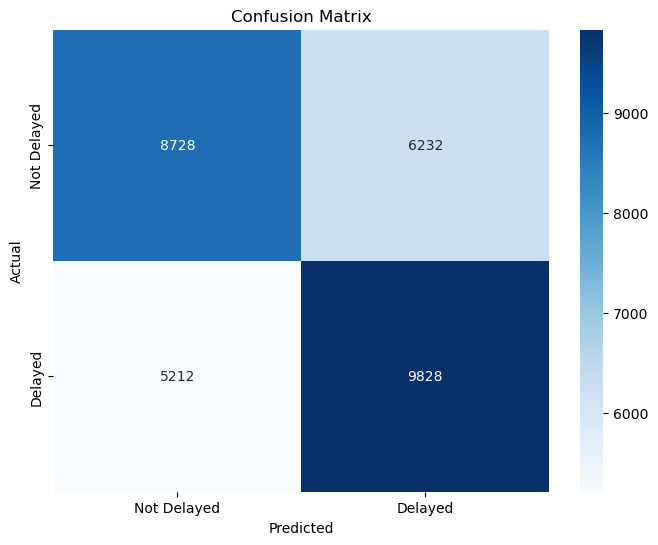

In [52]:
# Calculating confusion matrix
cm_bal = confusion_matrix(y_test_bal, y_pred_bal)
# Plotting a heat map of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_bal, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Not Delayed', 'Delayed'], 
            yticklabels=['Not Delayed', 'Delayed'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()